# Введение в обработку естественного языка
# Урок 8. Рекуррентные нейронные сети RNN LSTM GRU

# <font color='red'>Практическое задание</font>

### Домашнее задание к уроку 7

__Задание__<br>
Данные берем отызывы за лето<br>
На вебинаре мы говорили, что долгое время CNN и RNN архитектуры были конурируещими выяснить какая архитектура больше подходит для нашей задачи
1. построить свёрточные архитектуры
2. построить различные архитектуры с RNN
3. построить совместные архитектуры CNN -> RNN или (RNN -> CNN)

Выполнил ___Соковнин ИЛ___

In [1]:
import numpy as np
import pandas as pd
from string import punctuation

print (pd.__version__)

1.4.2


In [2]:
data = pd.read_excel(open('отзывы за лето.xls', 'rb'))
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [3]:
data["Content"].str.len().min(), data["Content"].str.len().max(), data["Content"].str.len().mean()
# (1.0, 1147.0, 56.039941902687)

(1.0, 1147.0, 56.039941902687)

In [4]:
data.shape

(20659, 3)

In [5]:
data.drop('Date', axis=1, inplace=True)

In [6]:
max_words = 3000
max_len = 110
num_classes = 1

# Training
epochs = 20
batch_size = 512
print_batch_n = 100

### Предобработка

In [7]:
import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [8]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

data['Content'] = data['Content'].apply(preprocess_text)

In [9]:
data.head(3)

,Rating,Content
0,5,it just works
1,4,целое удобноной приложениеиз минус хотеть боль...
2,5,отлично


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# # Разбиваем на train, test, val
# # https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c
X = data.drop(columns = ['Rating']).copy()
y = data['Rating']

train_size=0.8
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

test_size = 0.5
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_val.shape), print(y_val.shape)
print(X_test.shape), print(y_test.shape)

(16527, 1)
(16527,)
(2066, 1)
(2066,)
(2066, 1)
(2066,)


(None, None)

### Токенизация

In [12]:
train_corpus = " ".join(X_train["Content"])
train_corpus = train_corpus.lower()

In [13]:
train_corpus[:100]

'возможно перевести другой клиент карта деньга приложение тормозить обновление хороший приложение отл'

In [14]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
tokens[:10]

['возможно',
 'перевести',
 'другой',
 'клиент',
 'карта',
 'деньга',
 'приложение',
 'тормозить',
 'обновление',
 'хороший']

Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [16]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [17]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [18]:
tokens_filtered_top[:10]

['приложение',
 'удобно',
 'работать',
 'удобный',
 'отлично',
 'нравиться',
 'хороший',
 'отличный',
 'телефон',
 'супер']

In [19]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [20]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [21]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in X_train["Content"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in X_test["Content"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in X_val["Content"]], dtype=np.int32)

In [22]:
x_train.shape

(16527, 110)

### Создание модели

In [23]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, Flatten
from keras.callbacks import TensorBoard 
from keras.callbacks import EarlyStopping  

In [24]:
import pkg_resources
print(f"keras v{pkg_resources.get_distribution('keras').version}")

keras v2.7.0


In [25]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [26]:
num_classes = 6
y_train = tf.keras.utils.to_categorical(y_train['Rating'], num_classes)
y_test = tf.keras.utils.to_categorical(y_test['Rating'], num_classes)

In [27]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 110, 128)          384000    
                                                                 
 conv1d (Conv1D)             (None, 108, 128)          49280     
                                                                 
 activation (Activation)     (None, 108, 128)          0         
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                        

In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/20
30/30 [==============================] - 6s 170ms/step - loss: 1.2709 - accuracy: 0.6938 - val_loss: 0.9597 - val_accuracy: 0.7120
Epoch 2/20
30/30 [==============================] - 5s 146ms/step - loss: 0.8456 - accuracy: 0.7224 - val_loss: 0.7150 - val_accuracy: 0.7695


In [30]:
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print('\n')
print(f'max_words: {max_words}')
print(f'max_len: {max_len}')
print('Test score:', score[0])
print('Test accuracy:', score[1])
# print('Test score:', score)

5/5 [==============================] - 0s 68ms/step - loss: 0.7582 - accuracy: 0.7512


max_words: 3000
max_len: 110
Test score: 0.7582032680511475
Test accuracy: 0.75121009349823


### Предобработка

In [31]:
df_w2v = data.copy()

In [32]:
df_w2v.shape

(20659, 2)

In [33]:
# Сокращаем количество классов до 2
df_w2v = df_w2v[df_w2v['Rating'] != 3]
df_w2v['target'] = (df_w2v['Rating'] > 3)*1
df_w2v = df_w2v.drop(['Rating'], axis=1)

In [34]:
df_w2v['target'] = df_w2v['target'].astype(int)
df_w2v['target'].value_counts()

1    16724
0     3024
Name: target, dtype: int64

In [35]:
df_train = df_w2v.loc[:14000]
df_val = df_w2v.loc[14001:]

In [36]:
df_train['Content'] = df_train['Content'].apply(preprocess_text)
df_val['Content'] = df_val['Content'].apply(preprocess_text)

<ipython-input-36-18a355c3bd21>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Content'] = df_train['Content'].apply(preprocess_text)
<ipython-input-36-18a355c3bd21>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['Content'] = df_val['Content'].apply(preprocess_text)


### Токенизация

In [37]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['Content'] = df_train['Content'].apply(preprocess_text)
df_val['Content'] = df_val['Content'].apply(preprocess_text)
# df_test['text'] = df_test['text'].apply(preprocess_text)

<ipython-input-37-7fdbbb1602b8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Content'] = df_train['Content'].apply(preprocess_text)
<ipython-input-37-7fdbbb1602b8>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['Content'] = df_val['Content'].apply(preprocess_text)


In [38]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking

In [39]:
text_corpus_train = df_train['Content'].values
text_corpus_valid = df_val['Content'].values
# text_corpus_test = df_test['text'].values

In [40]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
# sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

# 
word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])
# 

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [41]:
len(sequences_train)

13404

In [42]:
y_train = df_train['target'].values
y_val = df_val['target'].values

In [43]:
X_train.shape, y_train.shape

((13404, 100), (13404,))

In [44]:
y_train, df_train

(array([1, 1, 1, ..., 1, 1, 1]),
                                                  Content  target
 0                                          it just works       1
 1      целое удобнона приложениеиз минус большой дост...       1
 2                                                отлично       1
 3      зависать 1 работа антивирус ранее пользоваться...       1
 4                                 удобно работать быстро       1
 ...                                                  ...     ...
 13996                                              норма       1
 13997  приложение ужасный пользоваться чтонуть выбор ...       0
 13998                                           устроить       1
 13999                                       удобнобыстро       1
 14000                                                          1
 
 [13404 rows x 2 columns])

In [45]:
import matplotlib.pyplot as plt

def plot_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
       
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train', 'test'], loc='upper left')

# <font color='blue'>1. построить свёрточные архитектуры</font>

In [46]:
from tensorflow.keras.layers import Input

In [47]:
num_classes = 1 
model = Sequential()
# model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=128,
              trainable=True,
              mask_zero=True))
    
model.add(Masking(mask_value=0.0))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          1145344   
                                                                 
 masking (Masking)           (None, 100, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 98, 128)           49280     
                                                                 
 activation_3 (Activation)   (None, 98, 128)           0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                      

In [48]:
# batch_size
X_train.shape, y_train.shape

((13404, 100), (13404,))

Epoch 1/20
24/24 [==============================] - 6s 188ms/step - loss: 0.4768 - accuracy: 0.8720 - val_loss: 0.3867 - val_accuracy: 0.8688
Epoch 2/20
24/24 [==============================] - 4s 158ms/step - loss: 0.3447 - accuracy: 0.8726 - val_loss: 0.3165 - val_accuracy: 0.8688


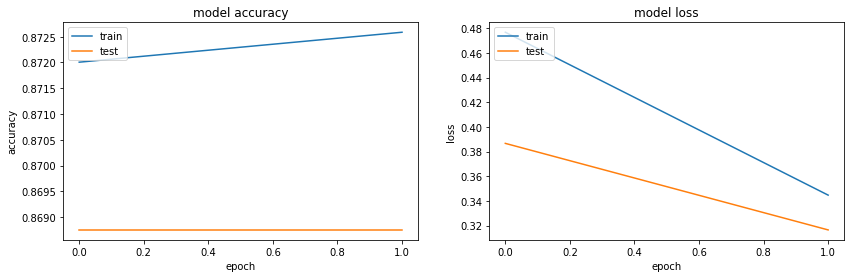

In [49]:
early_stopping=EarlyStopping(monitor='val_loss')  
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

plot_history(history)

In [50]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

13/13 [==============================] - 1s 63ms/step - loss: 0.4023 - accuracy: 0.7933


Test score: 0.40234702825546265
Test accuracy: 0.7933480739593506


# <font color='blue'>2. Построить различные архитектуры с RNN</font>

__Простая рекурентная модель SimpleRNN__

In [51]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=128,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(SimpleRNN(64))  # 64 - рекурентных ячеёки (количество слоёв, RNN-ячеек)!

model.add(Dense(124, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()

(13404, 100) (13404,)
Epoch 1/10
24/24 [==============================] - 14s 461ms/step - loss: 0.4071 - accuracy: 0.8594 - val_loss: 0.3086 - val_accuracy: 0.8732
Epoch 2/10
24/24 [==============================] - 11s 459ms/step - loss: 0.2563 - accuracy: 0.8962 - val_loss: 0.2417 - val_accuracy: 0.8926


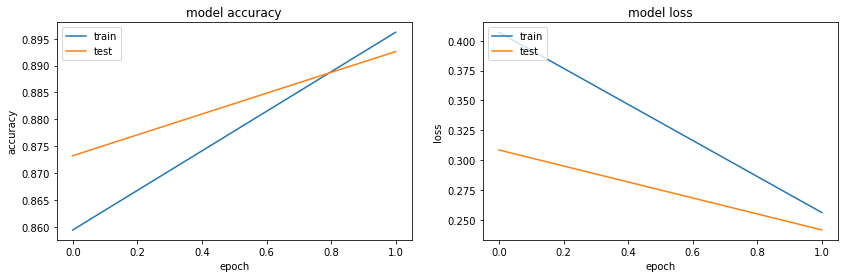

In [52]:
early_stopping=EarlyStopping(monitor='val_loss')  
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)

print(X_train.shape, y_train.shape)

history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    # callbacks=[early_stopping])
                    callbacks=[tensorboard, early_stopping])

plot_history(history)

In [53]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

13/13 [==============================] - 2s 160ms/step - loss: 0.2989 - accuracy: 0.8671


Test score: 0.2988642454147339
Test accuracy: 0.8671185374259949


__LSTM__

Epoch 1/10
24/24 [==============================] - 15s 446ms/step - loss: 0.4693 - accuracy: 0.8543 - val_loss: 0.3133 - val_accuracy: 0.8688
Epoch 2/10
24/24 [==============================] - 12s 493ms/step - loss: 0.2713 - accuracy: 0.8873 - val_loss: 0.2474 - val_accuracy: 0.8837


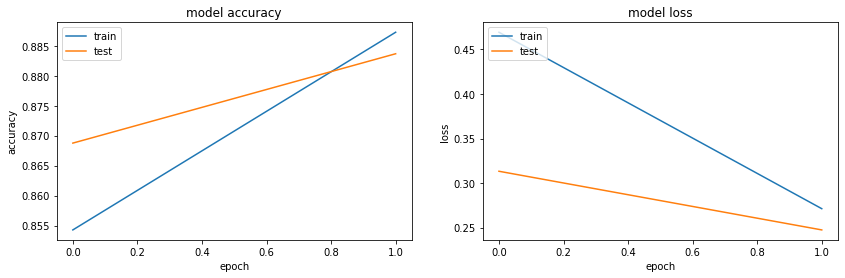

In [54]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=128,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(LSTM(64, recurrent_dropout=0.2))  # recurrent_dropout рвёт связи между RNN-ячейками
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

plot_history(history)

In [55]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

13/13 [==============================] - 3s 197ms/step - loss: 0.3091 - accuracy: 0.8677


Test score: 0.3091104030609131
Test accuracy: 0.867749035358429


__GRU__

Epoch 1/10
24/24 [==============================] - 15s 509ms/step - loss: 0.5016 - accuracy: 0.8576 - val_loss: 0.3342 - val_accuracy: 0.8688
Epoch 2/10
24/24 [==============================] - 11s 439ms/step - loss: 0.2559 - accuracy: 0.8797 - val_loss: 0.2409 - val_accuracy: 0.8732


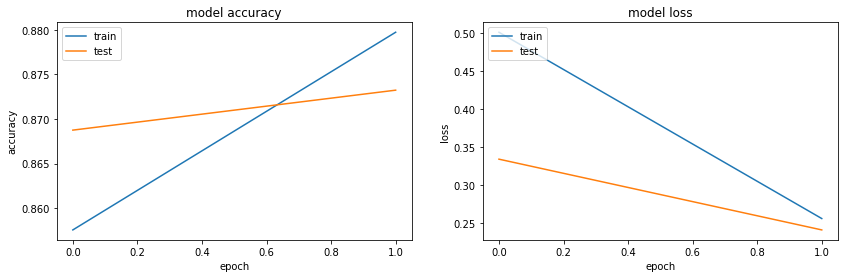

In [56]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=128,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(GRU(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

plot_history(history)

In [57]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

13/13 [==============================] - 3s 261ms/step - loss: 0.3140 - accuracy: 0.8428


Test score: 0.31398484110832214
Test accuracy: 0.8428436517715454


# <font color='blue'>3. Построить совместные архитектуры CNN -> RNN или (RNN -> CNN)</font>

__CNN + RNN__

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 128)          1145344   
                                                                 
 masking_4 (Masking)         (None, 100, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 64)           24640     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 124)               8060      
                                                                 
 dropout_3 (Dropout)         (None, 124)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                

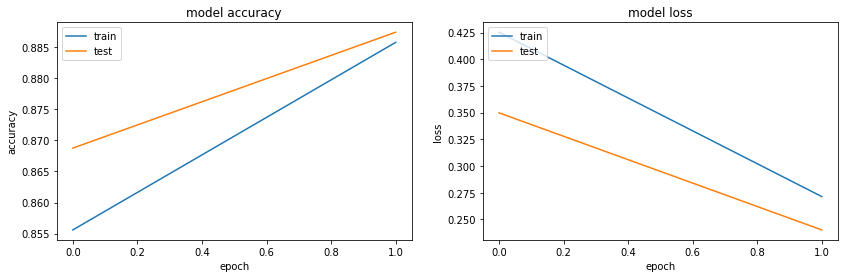

In [58]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=128,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding="same"))

model.add(SimpleRNN(64))  # 64 - рекурентных ячеёки (количество слоёв, RNN-ячеек)!

model.add(Dense(124, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

plot_history(history)

In [59]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

13/13 [==============================] - 1s 101ms/step - loss: 0.3130 - accuracy: 0.8515


Test score: 0.313017874956131
Test accuracy: 0.8515132665634155


__CNN + LSTM__

Epoch 1/10
24/24 [==============================] - 14s 442ms/step - loss: 0.4282 - accuracy: 0.8665 - val_loss: 0.3081 - val_accuracy: 0.8688
Epoch 2/10
24/24 [==============================] - 11s 429ms/step - loss: 0.2653 - accuracy: 0.8901 - val_loss: 0.2385 - val_accuracy: 0.8859


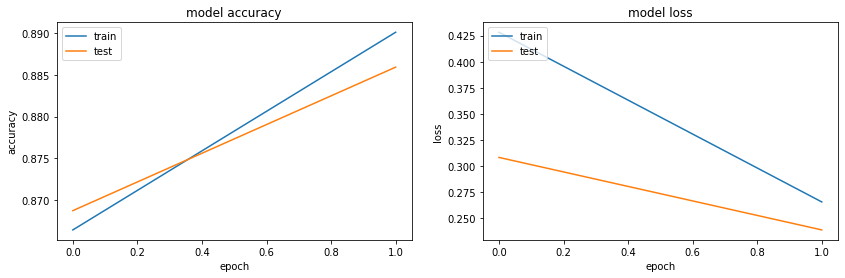

In [60]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=128,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding="same"))
model.add(LSTM(64, recurrent_dropout=0.2))  # recurrent_dropout рвёт связи между RNN-ячейками
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

plot_history(history)

In [61]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

13/13 [==============================] - 3s 197ms/step - loss: 0.3049 - accuracy: 0.8635


Test score: 0.30487334728240967
Test accuracy: 0.8634930849075317


__LSTM + CNN__

Epoch 1/10
24/24 [==============================] - 13s 425ms/step - loss: 0.4306 - accuracy: 0.8606 - val_loss: 0.3636 - val_accuracy: 0.8688
Epoch 2/10
24/24 [==============================] - 10s 396ms/step - loss: 0.3143 - accuracy: 0.8802 - val_loss: 0.2818 - val_accuracy: 0.8829


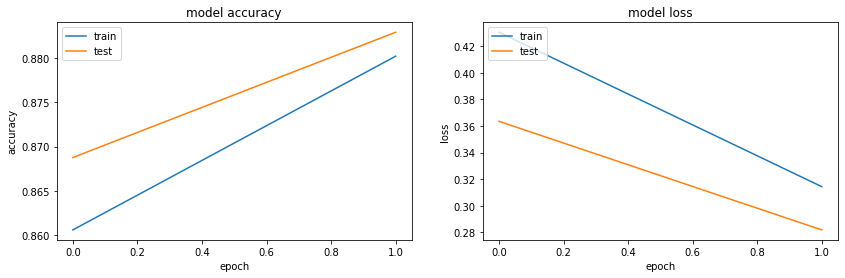

In [62]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)
)

model.add(Masking(mask_value=0.0))

model.add(LSTM(64, recurrent_dropout=0.2, return_sequences=True))  # recurrent_dropout рвёт связи между RNN-ячейками
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding="same"))


model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

plot_history(history)

In [63]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

13/13 [==============================] - 4s 309ms/step - loss: 0.3625 - accuracy: 0.8482


Test score: 0.3624567687511444
Test accuracy: 0.8482030034065247


__CNN + GRU__

Epoch 1/10
24/24 [==============================] - 12s 380ms/step - loss: 0.4926 - accuracy: 0.8476 - val_loss: 0.3364 - val_accuracy: 0.8688
Epoch 2/10
24/24 [==============================] - 9s 363ms/step - loss: 0.2659 - accuracy: 0.8740 - val_loss: 0.2428 - val_accuracy: 0.8688


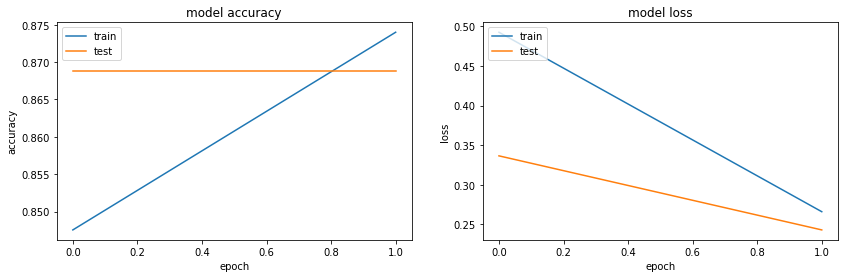

In [64]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=128,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding="same"))
model.add(GRU(64, recurrent_dropout=0.2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

plot_history(history)

In [65]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

13/13 [==============================] - 4s 279ms/step - loss: 0.3275 - accuracy: 0.8222


Test score: 0.32753103971481323
Test accuracy: 0.8221942186355591


__Выводы.__
Лучше всего сработали (в порядке убывания результата) следующие архитектуры:

1. SimpleRNN
2. LSTM
3. GRU
4. CNN

Их результаты отличаются не сильно.

SimpleRNN:	 (0.3091506361961365, 0.8668032884597778)<br>
LSTM:		 (0.31315749883651733, 0.8668032884597778)<br>
GRU:		 (0.31110599637031555, 0.8477301597595215)<br>
CNN:  		 (0.35694921016693115, 0.7933480739593506)<br>

CNN + SimpleRNN: (0.2870107591152191, 0.8748423457145691)<br>
CNN + LSTM:	 (0.3044297993183136, 0.8628625273704529)<br>
CNN + GRU:	 (0.31573957204818726, 0.8294451236724854)<br>